### Dataset:
https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

In [1]:
# Kaggle instalaltion in Colab # https://www.kaggle.com/general/74235
!pip install kaggle


In [2]:
!pip install transformers

     |████████████████████████████████| 2.5MB 5.4MB/s 
     |████████████████████████████████| 3.3MB 40.1MB/s 
     |████████████████████████████████| 901kB 49.3MB/s 


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mu666666","key":"c8683ac04dca3e3b317eb6d6d4644532"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Initialize and Authenticate Kaggle API
#from kaggle.api.kaggle_api_extended import kaggleApi 
#api = kaggleApi()
#api.authenticate()


In [6]:
!kaggle competitions download -c 'sentiment-analysis-on-movie-reviews'

  0% 0.00/494k [00:00<?, ?B/s]
100% 494k/494k [00:00<00:00, 69.0MB/s]
  0% 0.00/1.28M [00:00<?, ?B/s]
100% 1.28M/1.28M [00:00<00:00, 87.6MB/s]
  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 81.1MB/s]


In [7]:
!mkdir input
!unzip train.tsv.zip -d input
!unzip test.tsv.zip -d input

Archive:  train.tsv.zip
  inflating: input/train.tsv         
Archive:  test.tsv.zip
  inflating: input/test.tsv          


## Preprocessing Dataset

In [8]:
import pandas as pd
train_df = pd.read_csv('input/train.tsv', sep='\t')
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


The sentiment labels are:

0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive

4 - positive

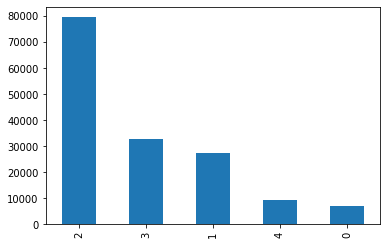

In [9]:
train_df['Sentiment'].value_counts().plot(kind='bar')

In [10]:
seq_len = 512
num_samples = len(train_df)

num_samples, seq_len

(156060, 512)

In [11]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [12]:
tokens = tokenizer(train_df['Phrase'].tolist(), 
                   max_length=seq_len,
                   truncation=True,
                   padding='max_length',
                   add_special_tokens=True,
                   return_tensors='np'
                   )

In [13]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [14]:
tokens['input_ids']

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]])

In [15]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [16]:
# Save these tokens as Numpy Binary Files
import numpy as np
with open('movie-xids.npy', 'wb') as f:
  np.save(f, tokens['input_ids'])
with open('movie-xmask.npy', 'wb') as f:
  np.save(f, tokens['attention_mask'])

In [17]:
arr = train_df['Sentiment'].values
arr.shape

(156060,)

In [18]:
# One-hot encode the lables
labels = np.zeros((num_samples, arr.max()+1))
labels[np.arange(num_samples), arr] = 1
labels.shape

(156060, 5)

In [19]:
with open('movie-labels.npy', 'wb') as f:
  np.save(f, labels)

# Building Dataset

In [20]:
import numpy as np

In [21]:
with open('movie-xids.npy', 'rb') as f:
  Xids = np.load(f, allow_pickle=True)
with open('movie-xmask.npy', 'rb') as f:
  Xmask = np.load(f, allow_pickle=True)
with open('movie-labels.npy', 'rb') as f:
  labels = np.load(f, allow_pickle=True)

In [22]:
Xids.shape, Xmask.shape, labels.shape

((156060, 512), (156060, 512), (156060, 5))

In [23]:
import tensorflow as tf


In [24]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [25]:
dataset.take(1)

<TakeDataset shapes: ((512,), (512,), (5,)), types: (tf.int64, tf.int64, tf.float64)>

In [26]:
#(input_ids, attention_mask), outputs

In [27]:
def map_func(input_ids, masks, labels):
  return {'input_ids': input_ids,
          'attention_mask': masks}, labels

In [28]:
dataset = dataset.map(map_func)

In [29]:
dataset.take(1)

<TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (5,)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

In [30]:
batch_size = 16

In [31]:
# Dataset Shuffle, Batch, Split, and Save
dataset = dataset.shuffle(100000).batch(batch_size, drop_remainder=True)

In [32]:
dataset.take(1)

<TakeDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 5)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

In [33]:
split = 0.9
size = Xids.shape[0]
size = int((Xids.shape[0] / batch_size) * split)

In [34]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [35]:
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

In [36]:
train_ds.element_spec == val_ds.element_spec

True

In [37]:
train_ds.element_spec

({'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [38]:
ds = tf.data.experimental.load('train', element_spec=train_ds.element_spec)

In [39]:
from transformers import TFAutoModel

In [40]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [41]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [42]:
import tensorflow as tf

In [43]:
# two inputs
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# transformer
embeddings = bert.bert(input_ids, attention_mask=mask) [1]

# classification head
x = tf.keras.layers.Dense(1024, activation='relu') (embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs') (x)


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [44]:
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [45]:
model.layers[2].trainable = False

In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         787456      bert[0][1]                   

In [47]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [48]:
element_spec = ({'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
                  'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
                  tf.TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [49]:
val_ds.element_spec

({'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [50]:
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)

In [51]:
train_ds.take(1)

<TakeDataset shapes: ({attention_mask: (16, 512), input_ids: (16, 512)}, (16, 5)), types: ({attention_mask: tf.int64, input_ids: tf.int64}, tf.float64)>

>> Always check the element_spec

In [52]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1
)

8778/8778 [==============================] - 3732s 424ms/step - loss: 1.1149 - accuracy: 0.5516 - val_loss: 1.0205 - val_accuracy: 0.5872


In [53]:
model.save('sentiment_model')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: sentiment_model/assets


INFO:tensorflow:Assets written to: sentiment_model/assets


# Load and Predict

In [54]:
import tensorflow as tf

In [56]:
model = tf.keras.models.load_model('sentiment_model')

In [57]:
from transformers import BertTokenizer

In [58]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [59]:
def prep_data(text):
  tokens = tokenizer(text, max_length=512, truncation=True,
                     padding='max_length', add_special_tokens=True,
                     return_tensors='tf')
  return {'input_ids': tokens['input_ids'], 
          'attention_mask': tokens['attention_mask']}

In [60]:
probs = model.predict(prep_data('You are a bad person'))[0]
probs

array([0.12571992, 0.27838773, 0.44086272, 0.12399528, 0.03103446],
      dtype=float32)

In [61]:
import numpy as np

In [62]:
np.argmax(probs)

2

# Predict using Test data

In [63]:
import pandas as pd
test_df = pd.read_csv('input/test.tsv', sep='\t')
test_df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [64]:
test_df.drop_duplicates(subset=['SentenceId'], keep='first')

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
15,156076,8546,Kidman is really the only thing that 's worth ...
93,156154,8547,Once you get into its rhythm ... the movie bec...
117,156178,8548,I kept wishing I was watching a documentary ab...
158,156219,8549,"Kinnear does n't aim for our sympathy , but ra..."
...,...,...,...
66220,222281,11851,Not sweet enough to liven up its predictable s...
66239,222300,11852,"Nasty , ugly , pointless and depressing , even..."
66253,222314,11853,"With tightly organized efficiency , numerous f..."
66280,222341,11854,They should have called it Gutterball .


In [65]:
test_df['Sentiment'] = None

In [ ]:
for i, row in test_df.iterrows():
  #print(row)
  tokens = prep_data(row['Phrase'])
  probs = model.predict(tokens)
  pred = np.argmax(probs)
  test_df.at[i, 'Sentiment'] = pred